# Importando librerías

In [1]:
import os
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from skimage.io import imread #read images from files
import matplotlib.patches as patches
from PIL import Image

import cv2

# Revisando los labels de train

In [2]:
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

# Me quedo solo con 1000 filas para que el procesamiento de esto sea más rápido

In [3]:
df = df.sample(1000)

In [4]:
cancer_positive = df[df["label"] == 1].sample(5)['id']


cancer_negative = df[df["label"] == 0].sample(5)['id']


In [5]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img



Text(0, 0.5, 'Tumor tissue samples')

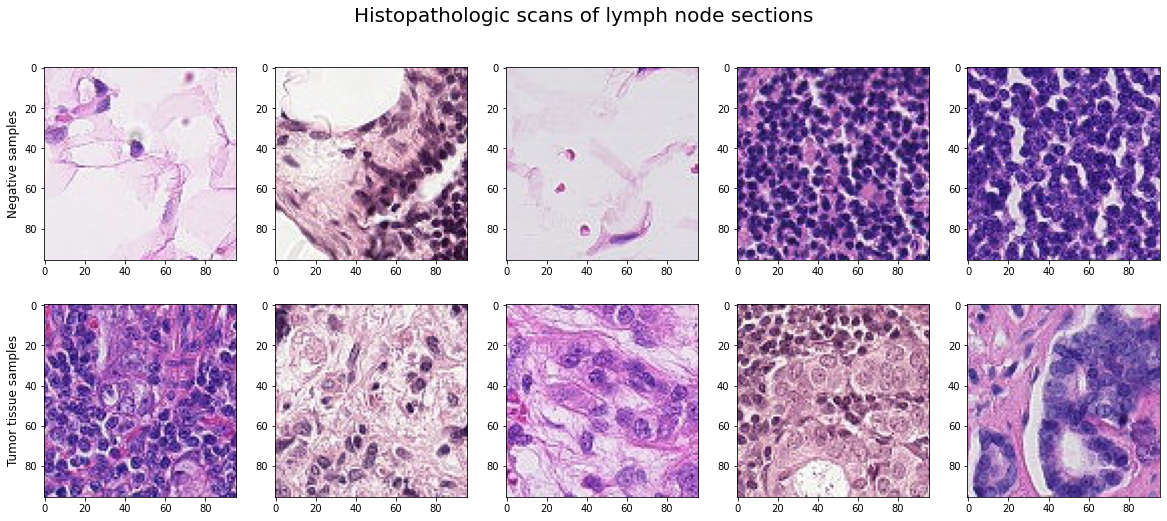

In [6]:

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
path_dir = '../input/histopathologic-cancer-detection'

# Negatives
for i, idx in enumerate(cancer_negative):
    path = os.path.join(path_dir, 'train', idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    
ax[0,0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(cancer_positive):
    path = os.path.join(path_dir, 'train', idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [7]:
# Leyendo imágenes
df['image_path'] = path_dir + '/train/' + df['id'] + '.tif'
df.sample(3)


,id,label,image_path
29810,74ba806286c6a14e5f97522eef21f1e6d0c731cb,1,../input/histopathologic-cancer-detection/trai...
203471,e5895d6810411ba9f5f44e05b48460b7b0fef98f,0,../input/histopathologic-cancer-detection/trai...
24977,f12d278c0c0e114d947c0500b3486e7f05d6d007,0,../input/histopathologic-cancer-detection/trai...


In [8]:
df['image'] = df['image_path'].map(imread)


In [9]:
df.sample(3)

,id,label,image_path,image
101719,ef2833cc6e5d911339aee8b86d1e73f4ab16947e,0,../input/histopathologic-cancer-detection/trai...,"[[[227, 139, 215], [197, 109, 183], [204, 117,..."
28539,546349d3b4ca461fadc2f1c5a19922e996896a71,1,../input/histopathologic-cancer-detection/trai...,"[[[123, 84, 175], [93, 48, 139], [102, 49, 141..."
177316,b9009d4e56fdce39f49546a4a3ade69fe0b8983b,0,../input/histopathologic-cancer-detection/trai...,"[[[225, 224, 229], [229, 229, 231], [230, 230,..."


# Testing 96x96x3 numpy arrays with Keras

Trying the code in https://keras.io/getting_started/intro_to_keras_for_engineers/#training-models-with-fit

In [10]:
# We know we have images from 96x96 in rgb
inputs = keras.Input(shape=(96, 96, 3))

from tensorflow.keras import layers
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling

# Center-crop images to 96x96 just in case
x = CenterCrop(height=96, width=96)(inputs)
# Rescale images to [0, 1]
x = Rescaling(scale=1.0 / 255)(x)

# Apply some convolution and pooling layers
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)

# Apply global average pooling to get flat feature vectors
x = layers.GlobalAveragePooling2D()(x)

# Add a dense classifier on top
# num_classes = 2
# outputs = layers.Dense(num_classes, activation="softmax")(x)

# Using Dense 1 because of binary prediction
outputs = layers.Dense(1, kernel_initializer='normal', activation='sigmoid')(x)
# Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-11-09 05:04:05.206787: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model = keras.Model(inputs=inputs, outputs=outputs)


In [12]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()],)

In [13]:
df['image'].shape

(1000,)

In [14]:
input_images = np.stack(list(df['image']), axis = 0)
input_images.shape

(1000, 96, 96, 3)

In [15]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
y = encoder.fit_transform(df['label'])

X_train, X_val, y_train, y_val = train_test_split(input_images, y, test_size=0.2, random_state=1)

In [16]:
model.fit(X_train, y_train, batch_size=32, epochs=10, 
    validation_data=(X_val, y_val),)

2022-11-09 05:04:06.605160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
25/25 [==============================] - 3s 71ms/step - loss: 0.6757 - binary_accuracy: 0.5750 - val_loss: 0.6528 - val_binary_accuracy: 0.6250
Epoch 2/10
25/25 [==============================] - 1s 59ms/step - loss: 0.6587 - binary_accuracy: 0.5900 - val_loss: 0.6251 - val_binary_accuracy: 0.6250
Epoch 3/10
25/25 [==============================] - 2s 62ms/step - loss: 0.6368 - binary_accuracy: 0.6037 - val_loss: 0.6267 - val_binary_accuracy: 0.7200
Epoch 4/10
25/25 [==============================] - 1s 59ms/step - loss: 0.6224 - binary_accuracy: 0.6313 - val_loss: 0.6353 - val_binary_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 1s 58ms/step - loss: 0.6111 - binary_accuracy: 0.6675 - val_loss: 0.5653 - val_binary_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 1s 57ms/step - loss: 0.5956 - binary_accuracy: 0.6812 - val_loss: 0.5486 - val_binary_accuracy: 0.7500
Epoch 7/10
25/25 [==============================] - 1s 57ms/step - los

In [17]:
# Evaluate the model on the test data using `evaluate`
results = model.evaluate(X_val, y_val, verbose=0)
print("test loss, test acc:", results)


test loss, test acc: [0.517299234867096, 0.7149999737739563]


In [18]:

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_val[:3])
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
predictions shape: (3, 1)


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
center_crop (CenterCrop)     (None, 96, 96, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0     